In [1]:
!pip install swig
!pip install gymnasium["box2d"]
import numpy as np
if not hasattr(np, 'bool8'):
    np.bool8 = np.bool_

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 22.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 374.4/374.4 kB 5.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for box2d-py: filename=box2d_py-2.3.5-cp311-cp311-linux_x86_64.whl size=2379368 sha256=c0dd42f02f3cb83b2913c15f8a0ed23b518a719c0b525df929b793db90ecb92a
  Stored in directory: /root/.cache/pip/wheels/ab/f1/0c/d56f4a2bdd12bae0a0693ec33f2f0daadb5eb9753c78fa5308
Successfully built box2d-py


/tmp/ipykernel_13/262537328.py:4: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not hasattr(np, 'bool8'):


<frozen importlib._bootstrap>:241: DeprecationWarning: builtin type SwigPyPacked has no __module__ attribute
<frozen importlib._bootstrap>:241: DeprecationWarning: builtin type SwigPyObject has no __module__ attribute
<frozen importlib._bootstrap>:241: DeprecationWarning: builtin type swigvarlink has no __module__ attribute
/usr/local/lib/python3.11/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.11/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.11/dist-packages/gym/utils/passive_env_checker.py

Episode 0, Reward: -17.88, Avg Reward: -17.88
Episode 10, Reward: 1.78, Avg Reward: -24.93
Episode 20, Reward: -5.98, Avg Reward: -17.81
Episode 30, Reward: -2.37, Avg Reward: -14.63
Episode 40, Reward: -2.88, Avg Reward: -11.69
Episode 50, Reward: -23.90, Avg Reward: -10.23
Episode 60, Reward: -54.59, Avg Reward: -10.87
Episode 70, Reward: -12.64, Avg Reward: -12.76
Episode 80, Reward: -0.21, Avg Reward: -11.58
Episode 90, Reward: 4.01, Avg Reward: -10.57
Episode 100, Reward: -0.52, Avg Reward: -11.20
Episode 110, Reward: -9.49, Avg Reward: -9.12
Episode 120, Reward: 0.93, Avg Reward: -8.40
Episode 130, Reward: 6.94, Avg Reward: -7.36
Episode 140, Reward: -21.94, Avg Reward: -7.76
Episode 150, Reward: 6.10, Avg Reward: -8.28
Episode 160, Reward: 1.66, Avg Reward: -7.04
Episode 170, Reward: -0.50, Avg Reward: -3.80
Episode 180, Reward: 28.88, Avg Reward: -3.00
Episode 190, Reward: 2.11, Avg Reward: -2.33
Episode 200, Reward: 9.24, Avg Reward: 0.44
Episode 210, Reward: 17.98, Avg Reward

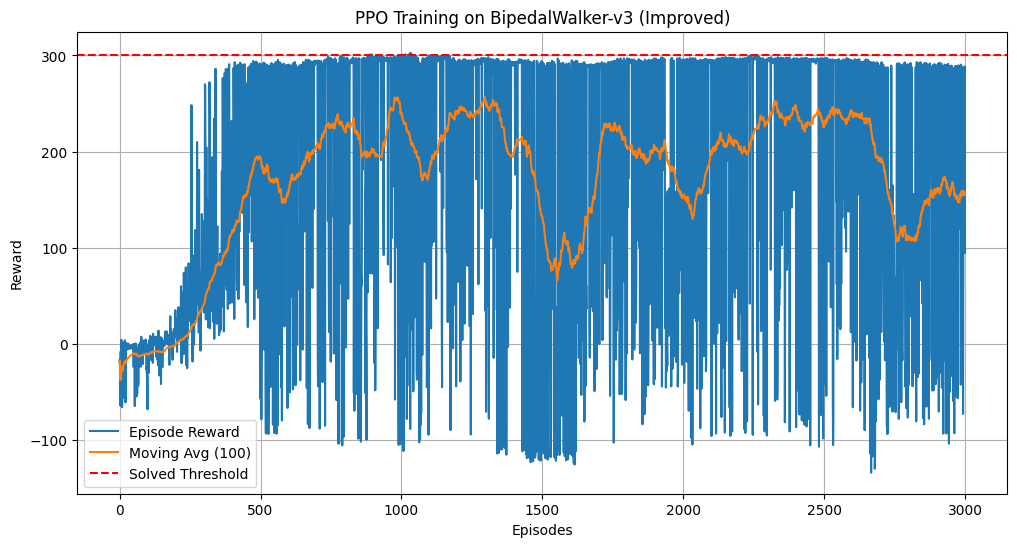

Evaluation 1: Reward = 21.08
Evaluation 2: Reward = 287.35
Evaluation 3: Reward = -67.13
Evaluation 4: Reward = 286.18
Evaluation 5: Reward = 283.98
Evaluation 6: Reward = 86.89
Evaluation 7: Reward = 61.59
Evaluation 8: Reward = -80.17
Evaluation 9: Reward = 285.45
Evaluation 10: Reward = 150.61

Average Evaluation Reward: 131.58


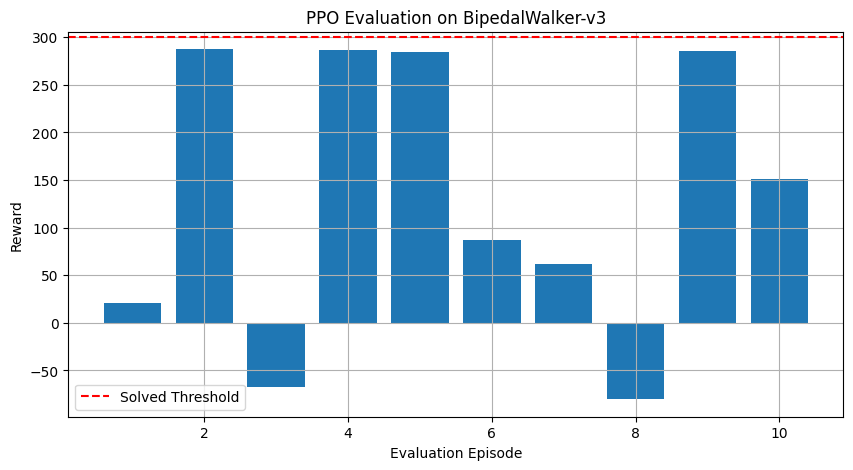

In [2]:
import gym
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.distributions import Normal
import matplotlib.pyplot as plt

# Reproducibility
np.random.seed(42)
torch.manual_seed(42)

env = gym.make("BipedalWalker-v3")
env.reset(seed=42)
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.shape[0]

# Hyperparameters
HIDDEN_SIZE = 256
LEARNING_RATE = 1e-4
GAMMA = 0.99
GAE_LAMBDA = 0.95
CLIP_EPS = 0.2
ENTROPY_COEFF = 0.001
K_EPOCHS = 15
BATCH_SIZE = 4096
MINI_BATCH_SIZE = 512
MAX_EPISODES = 3000
TARGET_REWARD = 300

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# === State Normalizer ===
class RunningStat:
    def __init__(self, shape):
        self.mean = np.zeros(shape)
        self.var = np.ones(shape)
        self.count = 1e-4

    def update(self, x):
        batch_mean = np.mean(x, axis=0)
        batch_var = np.var(x, axis=0)
        batch_count = x.shape[0]

        delta = batch_mean - self.mean
        total_count = self.count + batch_count

        new_mean = self.mean + delta * batch_count / total_count
        m_a = self.var * self.count
        m_b = batch_var * batch_count
        M2 = m_a + m_b + delta**2 * self.count * batch_count / total_count
        new_var = M2 / total_count

        self.mean, self.var, self.count = new_mean, new_var, total_count

    def normalize(self, x):
        return (x - self.mean) / (np.sqrt(self.var) + 1e-8)

# === Model ===
class ActorCritic(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(ActorCritic, self).__init__()
        self.actor = nn.Sequential(
            nn.Linear(state_dim, HIDDEN_SIZE),
            nn.ReLU(),
            nn.Linear(HIDDEN_SIZE, HIDDEN_SIZE),
            nn.ReLU(),
            nn.Linear(HIDDEN_SIZE, action_dim)
        )
        self.actor_std = nn.Parameter(torch.ones(1, action_dim) * 0.5)

        self.critic = nn.Sequential(
            nn.Linear(state_dim, HIDDEN_SIZE),
            nn.ReLU(),
            nn.Linear(HIDDEN_SIZE, HIDDEN_SIZE),
            nn.ReLU(),
            nn.Linear(HIDDEN_SIZE, 1)
        )

    def get_action(self, state):
        mu = torch.tanh(self.actor(state))  # smooth output
        std = self.actor_std.expand_as(mu)
        dist = Normal(mu, std)
        action = dist.sample()
        log_prob = dist.log_prob(action).sum(1)
        return action, log_prob, dist.entropy().sum(1), self.critic(state)

    def evaluate(self, states, actions):
        mu = torch.tanh(self.actor(states))  # keep consistent
        std = self.actor_std.expand_as(mu)
        dist = Normal(mu, std)

        log_probs = dist.log_prob(actions).sum(1)
        entropy = dist.entropy().sum(1)
        values = self.critic(states).squeeze()
        return log_probs, entropy, values

# === PPO Algorithm ===
class PPO:
    def __init__(self):
        self.model = ActorCritic(state_dim, action_dim).to(device)
        self.optimizer = optim.Adam(self.model.parameters(), lr=LEARNING_RATE)

    def compute_gae(self, rewards, masks, values, next_value):
        values = values + [next_value]
        gae = 0
        returns = []
        for step in reversed(range(len(rewards))):
            delta = rewards[step] + GAMMA * values[step + 1] * masks[step] - values[step]
            gae = delta + GAMMA * GAE_LAMBDA * masks[step] * gae
            returns.insert(0, gae + values[step])
        return returns

    def update(self, memory, stat):
        states = stat.normalize(np.array(memory['states']))
        states = torch.FloatTensor(states).to(device)
        actions = torch.FloatTensor(np.array(memory['actions'])).to(device)
        old_log_probs = torch.FloatTensor(memory['log_probs']).to(device)
        returns = torch.FloatTensor(memory['returns']).to(device)
        values = torch.FloatTensor(memory['values']).to(device)

        advantages = returns - values
        advantages = (advantages - advantages.mean()) / (advantages.std() + 1e-8)

        for _ in range(K_EPOCHS):
            idx = np.random.permutation(len(states))
            for start in range(0, len(states), MINI_BATCH_SIZE):
                end = start + MINI_BATCH_SIZE
                batch_idx = idx[start:end]

                log_probs, entropy, values_eval = self.model.evaluate(states[batch_idx], actions[batch_idx])
                ratios = (log_probs - old_log_probs[batch_idx]).exp()

                surr1 = ratios * advantages[batch_idx]
                surr2 = torch.clamp(ratios, 1 - CLIP_EPS, 1 + CLIP_EPS) * advantages[batch_idx]
                actor_loss = -torch.min(surr1, surr2).mean()
                critic_loss = (returns[batch_idx] - values_eval).pow(2).mean()

                loss = actor_loss + 0.5 * critic_loss - ENTROPY_COEFF * entropy.mean()

                self.optimizer.zero_grad()
                loss.backward()
                nn.utils.clip_grad_norm_(self.model.parameters(), 0.5)
                self.optimizer.step()

def train():
    ppo = PPO()
    stat = RunningStat(state_dim)
    all_rewards = []
    moving_avg = []

    for episode in range(MAX_EPISODES):
        memory = {'states': [], 'actions': [], 'log_probs': [], 'rewards': [],
                  'masks': [], 'values': [], 'returns': []}
        state = env.reset()
        episode_reward = 0

        while True:
            norm_state = stat.normalize(state).reshape(1, -1)
            state_tensor = torch.FloatTensor(norm_state).to(device)
            action, log_prob, _, value = ppo.model.get_action(state_tensor)
            action_np = action.cpu().numpy()[0]

            next_state, reward, done, _ = env.step(np.clip(action_np, -1.0, 1.0))
            reward = np.clip(reward, -1.0, 1.0) if episode < 500 else reward

            memory['states'].append(state)
            memory['actions'].append(action_np)
            memory['log_probs'].append(log_prob.item())
            memory['rewards'].append(reward)
            memory['masks'].append(1 - done)
            memory['values'].append(value.item())

            state = next_state
            episode_reward += reward
            if done:
                break

        stat.update(np.array(memory['states']))
        with torch.no_grad():
            next_state_tensor = torch.FloatTensor(stat.normalize(state)).unsqueeze(0).to(device)
            next_value = ppo.model.critic(next_state_tensor).item()

        memory['returns'] = ppo.compute_gae(memory['rewards'], memory['masks'], memory['values'], next_value)
        ppo.update(memory, stat)

        all_rewards.append(episode_reward)
        avg = np.mean(all_rewards[-100:])
        moving_avg.append(avg)

        if episode % 10 == 0:
            print(f"Episode {episode}, Reward: {episode_reward:.2f}, Avg Reward: {avg:.2f}")
        if episode % 500 == 0:
            env.render()

        if avg >= TARGET_REWARD:
            print(f"Environment solved in {episode} episodes!")
            break

    # Plot training curve
    plt.figure(figsize=(12, 6))
    plt.plot(all_rewards, label="Episode Reward")
    plt.plot(moving_avg, label="Moving Avg (100)")
    plt.axhline(y=TARGET_REWARD, color='r', linestyle='--', label="Solved Threshold")
    plt.xlabel("Episodes")
    plt.ylabel("Reward")
    plt.title("PPO Training on BipedalWalker-v3 (Improved)")
    plt.legend()
    plt.grid()
    plt.show()

    return ppo, stat

def evaluate(agent, stat, episodes=10):
    rewards = []
    for i in range(episodes):
        state = env.reset()
        total_reward = 0
        done = False
        while not done:
            state_tensor = torch.FloatTensor(stat.normalize(state)).unsqueeze(0).to(device)
            with torch.no_grad():
                mu = torch.tanh(agent.model.actor(state_tensor))
            action = mu[0].cpu().numpy()
            state, reward, done, _ = env.step(np.clip(action, -1.0, 1.0))
            total_reward += reward
        rewards.append(total_reward)
        print(f"Evaluation {i+1}: Reward = {total_reward:.2f}")

    avg = np.mean(rewards)
    print(f"\nAverage Evaluation Reward: {avg:.2f}")

    plt.figure(figsize=(10, 5))
    plt.bar(range(1, episodes + 1), rewards)
    plt.axhline(y=TARGET_REWARD, color='r', linestyle='--', label='Solved Threshold')
    plt.xlabel('Evaluation Episode')
    plt.ylabel('Reward')
    plt.title('PPO Evaluation on BipedalWalker-v3')
    plt.legend()
    plt.grid()
    plt.show()

if __name__ == "__main__":
    trained_agent, stat = train()
    evaluate(trained_agent, stat)


/usr/local/lib/python3.11/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.11/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/tmp/ipykernel_13/1904713336.py:113: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  states = torch.FloatTensor(memory.states)


Episode 0, Reward: -122.07, Avg Reward (100): -122.07
Episode 10, Reward: -97.49, Avg Reward (100): -135.04
Episode 20, Reward: -417.45, Avg Reward (100): -278.68
Episode 30, Reward: -276.78, Avg Reward (100): -268.85
Episode 40, Reward: -420.55, Avg Reward (100): -267.59
Episode 50, Reward: -195.32, Avg Reward (100): -285.69
Episode 60, Reward: -477.99, Avg Reward (100): -291.46
Episode 70, Reward: -325.09, Avg Reward (100): -282.82
Episode 80, Reward: -114.34, Avg Reward (100): -270.99
Episode 90, Reward: -96.95, Avg Reward (100): -262.78
Episode 100, Reward: -312.63, Avg Reward (100): -262.31
Episode 110, Reward: -82.74, Avg Reward (100): -263.27
Episode 120, Reward: -101.99, Avg Reward (100): -230.94
Episode 130, Reward: -209.02, Avg Reward (100): -223.25
Episode 140, Reward: -127.86, Avg Reward (100): -214.14
Episode 150, Reward: -432.26, Avg Reward (100): -197.79
Episode 160, Reward: -577.67, Avg Reward (100): -208.33
Episode 170, Reward: -832.95, Avg Reward (100): -244.67
Episod

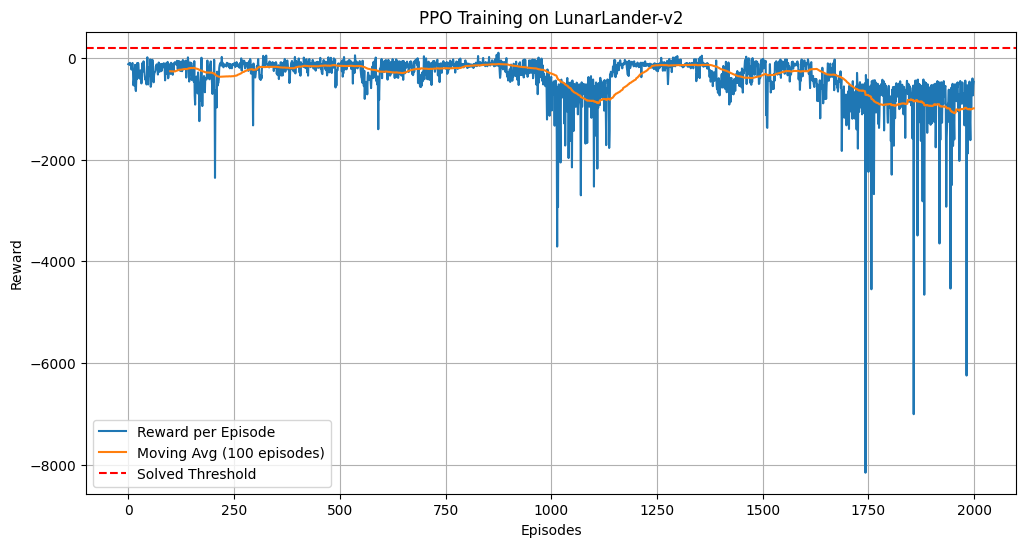

Eval 1: Reward = -637.15
Eval 2: Reward = -1546.51
Eval 3: Reward = -448.67
Eval 4: Reward = -532.42
Eval 5: Reward = -612.29
Eval 6: Reward = -642.92
Eval 7: Reward = -1365.63
Eval 8: Reward = -418.21
Eval 9: Reward = -575.11
Eval 10: Reward = -1709.77


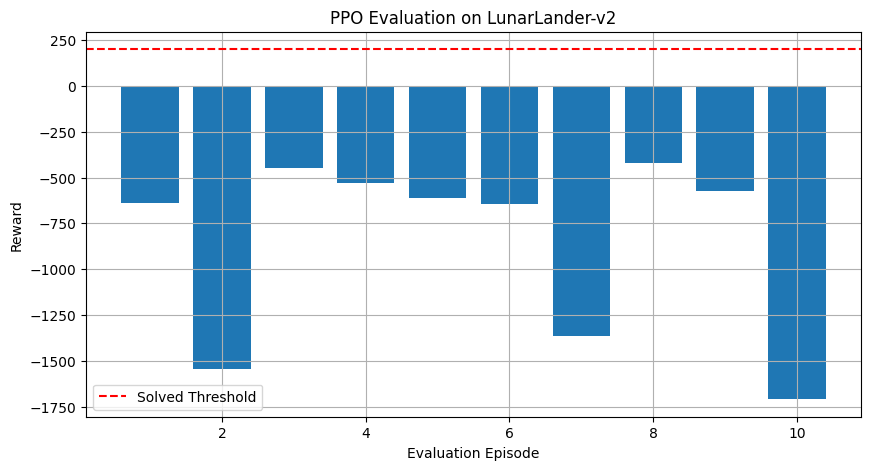

Average Eval Reward: -848.87


In [3]:
import gym
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.distributions import Categorical
import matplotlib.pyplot as plt

# Hyperparameters
GAMMA = 0.99
GAE_LAMBDA = 0.95
CLIP_EPS = 0.2
LR = 3e-4
UPDATE_EPOCHS = 4
BATCH_SIZE = 64
EPISODES = 2000
EVAL_EPISODES = 10

env = gym.make('LunarLander-v2')
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.n

# Actor-Critic Network
class ActorCritic(nn.Module):
    def __init__(self, state_dim, action_dim, hidden_size=128):
        super(ActorCritic, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(state_dim, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU()
        )
        self.actor = nn.Linear(hidden_size, action_dim)
        self.critic = nn.Linear(hidden_size, 1)

    def forward(self, x):
        x = self.fc(x)
        return self.actor(x), self.critic(x)

    def get_action(self, state):
        logits, value = self.forward(state)
        dist = Categorical(logits=logits)
        action = dist.sample()
        log_prob = dist.log_prob(action)
        return action.item(), log_prob, value

    def evaluate_actions(self, states, actions):
        logits, values = self.forward(states)
        dist = Categorical(logits=logits)
        log_probs = dist.log_prob(actions)
        entropy = dist.entropy()
        return log_probs, entropy, values.squeeze()

# Storage
class Memory:
    def __init__(self):
        self.states, self.actions, self.log_probs = [], [], []
        self.rewards, self.dones, self.values = [], [], []

    def store(self, state, action, log_prob, reward, done, value):
        self.states.append(state)
        self.actions.append(action)
        self.log_probs.append(log_prob)
        self.rewards.append(reward)
        self.dones.append(done)
        self.values.append(value)

    def compute_gae(self, next_value):
        values = self.values + [next_value]
        advantages, returns = [], []
        gae = 0
        for t in reversed(range(len(self.rewards))):
            delta = self.rewards[t] + GAMMA * values[t+1] * (1 - self.dones[t]) - values[t]
            gae = delta + GAMMA * GAE_LAMBDA * (1 - self.dones[t]) * gae
            advantages.insert(0, gae)
        advantages = torch.tensor(advantages, dtype=torch.float32)
        returns = advantages + torch.tensor(self.values, dtype=torch.float32)
        return advantages, returns

    def clear(self):
        self.__init__()

# PPO Agent
model = ActorCritic(state_dim, action_dim)
optimizer = optim.Adam(model.parameters(), lr=LR)
memory = Memory()

episode_rewards = []
moving_avg = []

for episode in range(EPISODES):
    state = env.reset()
    total_reward = 0
    done = False

    while not done:
        state_tensor = torch.FloatTensor(state)
        action, log_prob, value = model.get_action(state_tensor)
        next_state, reward, done, _ = env.step(action)

        memory.store(state, action, log_prob, reward, done, value.item())
        state = next_state
        total_reward += reward

    with torch.no_grad():
        next_state_tensor = torch.FloatTensor(state)
        _, next_value = model.forward(next_state_tensor)

    # Compute GAE and returns
    advantages, returns = memory.compute_gae(next_value.item())

    # Prepare batches
    states = torch.FloatTensor(memory.states)
    actions = torch.LongTensor(memory.actions)
    old_log_probs = torch.stack(memory.log_probs).detach()
    returns = returns.detach()
    advantages = (advantages - advantages.mean()) / (advantages.std() + 1e-8)

    # PPO update
    for _ in range(UPDATE_EPOCHS):
        idxs = np.arange(len(states))
        np.random.shuffle(idxs)
        for i in range(0, len(states), BATCH_SIZE):
            batch_idx = idxs[i:i + BATCH_SIZE]
            batch_states = states[batch_idx]
            batch_actions = actions[batch_idx]
            batch_old_log_probs = old_log_probs[batch_idx]
            batch_returns = returns[batch_idx]
            batch_advantages = advantages[batch_idx]

            log_probs, entropy, values = model.evaluate_actions(batch_states, batch_actions)
            ratio = torch.exp(log_probs - batch_old_log_probs)

            surr1 = ratio * batch_advantages
            surr2 = torch.clamp(ratio, 1 - CLIP_EPS, 1 + CLIP_EPS) * batch_advantages
            actor_loss = -torch.min(surr1, surr2).mean()
            critic_loss = (batch_returns - values).pow(2).mean()
            loss = actor_loss + 0.5 * critic_loss - 0.01 * entropy.mean()

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

    episode_rewards.append(total_reward)
    memory.clear()

    if len(episode_rewards) >= 100:
        avg = np.mean(episode_rewards[-100:])
        moving_avg.append(avg)
        if avg >= 200:
            print(f"Solved at episode {episode} with average reward {avg:.2f}")
    if episode % 10 == 0:
        print(f"Episode {episode}, Reward: {total_reward:.2f}, Avg Reward (100): {np.mean(episode_rewards[-100:]):.2f}")

# Plot training rewards
plt.figure(figsize=(12, 6))
plt.plot(episode_rewards, label='Reward per Episode')
if moving_avg:
    plt.plot(range(99, 99 + len(moving_avg)), moving_avg, label='Moving Avg (100 episodes)')
plt.axhline(y=200, color='r', linestyle='--', label='Solved Threshold')
plt.xlabel('Episodes')
plt.ylabel('Reward')
plt.title('PPO Training on LunarLander-v2')
plt.legend()
plt.grid()
plt.show()

# Evaluation
eval_rewards = []
for i in range(EVAL_EPISODES):
    state = env.reset()
    total_reward = 0
    done = False
    while not done:
        with torch.no_grad():
            logits, _ = model(torch.FloatTensor(state))
            action = torch.argmax(logits).item()
        state, reward, done, _ = env.step(action)
        total_reward += reward
    eval_rewards.append(total_reward)
    print(f"Eval {i+1}: Reward = {total_reward:.2f}")

# Plot evaluation rewards
plt.figure(figsize=(10, 5))
plt.bar(range(1, EVAL_EPISODES + 1), eval_rewards)
plt.axhline(y=200, color='r', linestyle='--', label='Solved Threshold')
plt.xlabel("Evaluation Episode")
plt.ylabel("Reward")
plt.title("PPO Evaluation on LunarLander-v2")
plt.legend()
plt.grid()
plt.show()

print(f"Average Eval Reward: {np.mean(eval_rewards):.2f}")


Episode 0, Reward: 12.00, Avg (100): 12.00
Episode 10, Reward: 13.00, Avg (100): 27.91
Episode 20, Reward: 35.00, Avg (100): 25.57
Episode 30, Reward: 15.00, Avg (100): 25.13
Episode 40, Reward: 24.00, Avg (100): 24.66
Episode 50, Reward: 17.00, Avg (100): 24.67
Episode 60, Reward: 22.00, Avg (100): 24.74
Episode 70, Reward: 27.00, Avg (100): 24.86
Episode 80, Reward: 9.00, Avg (100): 23.63
Episode 90, Reward: 11.00, Avg (100): 22.62
Episode 100, Reward: 11.00, Avg (100): 21.91
Episode 110, Reward: 26.00, Avg (100): 21.18
Episode 120, Reward: 11.00, Avg (100): 21.12
Episode 130, Reward: 10.00, Avg (100): 19.86
Episode 140, Reward: 11.00, Avg (100): 18.86
Episode 150, Reward: 18.00, Avg (100): 17.97
Episode 160, Reward: 22.00, Avg (100): 17.63
Episode 170, Reward: 20.00, Avg (100): 17.49
Episode 180, Reward: 13.00, Avg (100): 18.30
Episode 190, Reward: 73.00, Avg (100): 20.78
Episode 200, Reward: 23.00, Avg (100): 21.64
Episode 210, Reward: 13.00, Avg (100): 21.36
Episode 220, Reward: 3

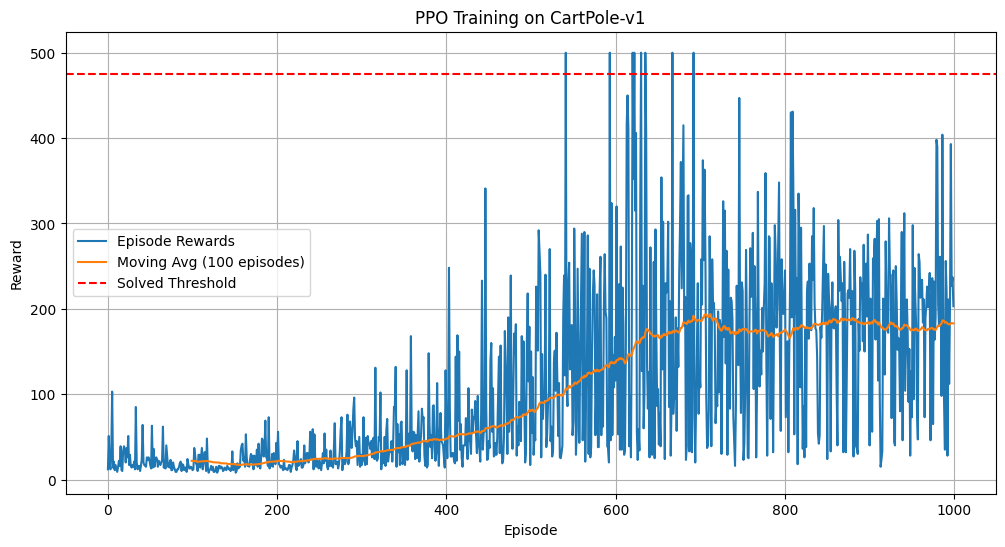

Eval 1: Reward = 258.00
Eval 2: Reward = 250.00
Eval 3: Reward = 252.00
Eval 4: Reward = 251.00
Eval 5: Reward = 246.00
Eval 6: Reward = 254.00
Eval 7: Reward = 260.00
Eval 8: Reward = 270.00
Eval 9: Reward = 263.00
Eval 10: Reward = 253.00


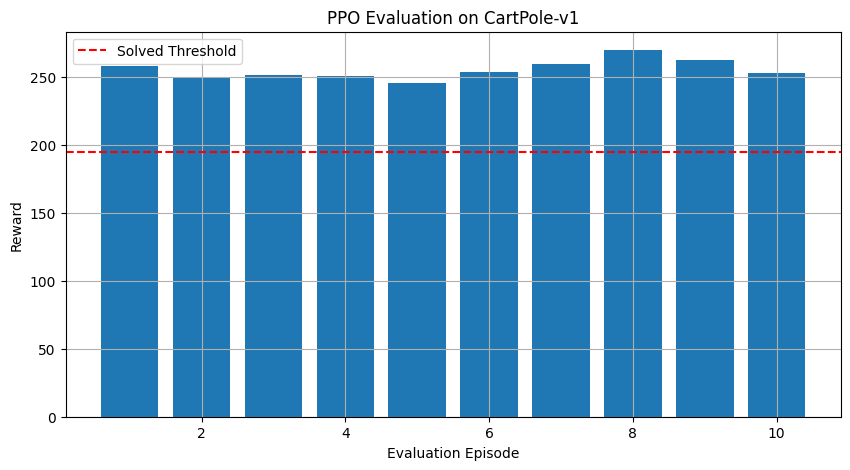

Avg Evaluation Reward: 255.70


In [4]:
import gym
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.distributions import Categorical
import matplotlib.pyplot as plt

# Hyperparameters
GAMMA = 0.99
GAE_LAMBDA = 0.95
CLIP_EPS = 0.2
LR = 3e-4
UPDATE_EPOCHS = 4
BATCH_SIZE = 64
EPISODES = 1000
EVAL_EPISODES = 10

env = gym.make("CartPole-v1")
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.n

# Actor-Critic Network
class ActorCritic(nn.Module):
    def __init__(self, state_dim, action_dim, hidden_size=64):
        super(ActorCritic, self).__init__()
        self.shared = nn.Sequential(
            nn.Linear(state_dim, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU()
        )
        self.actor = nn.Linear(hidden_size, action_dim)
        self.critic = nn.Linear(hidden_size, 1)

    def forward(self, x):
        x = self.shared(x)
        return self.actor(x), self.critic(x)

    def get_action(self, state):
        logits, value = self.forward(state)
        dist = Categorical(logits=logits)
        action = dist.sample()
        log_prob = dist.log_prob(action)
        return action.item(), log_prob, value

    def evaluate(self, states, actions):
        logits, values = self.forward(states)
        dist = Categorical(logits=logits)
        log_probs = dist.log_prob(actions)
        entropy = dist.entropy()
        return log_probs, entropy, values.squeeze()

# GAE Memory Buffer
class Memory:
    def __init__(self):
        self.clear()

    def store(self, state, action, log_prob, reward, done, value):
        self.states.append(state)
        self.actions.append(action)
        self.log_probs.append(log_prob)
        self.rewards.append(reward)
        self.dones.append(done)
        self.values.append(value)

    def compute_gae(self, next_value):
        values = self.values + [next_value]
        advantages, returns = [], []
        gae = 0
        for t in reversed(range(len(self.rewards))):
            delta = self.rewards[t] + GAMMA * values[t+1] * (1 - self.dones[t]) - values[t]
            gae = delta + GAMMA * GAE_LAMBDA * (1 - self.dones[t]) * gae
            advantages.insert(0, gae)
        advantages = torch.tensor(advantages, dtype=torch.float32)
        returns = advantages + torch.tensor(self.values, dtype=torch.float32)
        return advantages, returns

    def clear(self):
        self.states, self.actions, self.log_probs = [], [], []
        self.rewards, self.dones, self.values = [], [], []

# Agent setup
model = ActorCritic(state_dim, action_dim)
optimizer = optim.Adam(model.parameters(), lr=LR)
memory = Memory()

episode_rewards = []
moving_avg = []

# Training
for episode in range(EPISODES):
    state = env.reset()
    total_reward = 0
    done = False

    while not done:
        state_tensor = torch.FloatTensor(state)
        action, log_prob, value = model.get_action(state_tensor)
        next_state, reward, done, _ = env.step(action)

        memory.store(state, action, log_prob, reward, done, value.item())
        state = next_state
        total_reward += reward

    with torch.no_grad():
        next_state_tensor = torch.FloatTensor(state)
        _, next_value = model.forward(next_state_tensor)

    advantages, returns = memory.compute_gae(next_value.item())

    # Prepare training data
    states = torch.FloatTensor(memory.states)
    actions = torch.LongTensor(memory.actions)
    old_log_probs = torch.stack(memory.log_probs).detach()
    advantages = (advantages - advantages.mean()) / (advantages.std() + 1e-8)
    returns = returns.detach()

    # PPO Update
    for _ in range(UPDATE_EPOCHS):
        indices = np.arange(len(states))
        np.random.shuffle(indices)
        for i in range(0, len(states), BATCH_SIZE):
            idx = indices[i:i + BATCH_SIZE]
            b_states = states[idx]
            b_actions = actions[idx]
            b_old_log_probs = old_log_probs[idx]
            b_advantages = advantages[idx]
            b_returns = returns[idx]

            log_probs, entropy, values = model.evaluate(b_states, b_actions)
            ratio = torch.exp(log_probs - b_old_log_probs)
            surr1 = ratio * b_advantages
            surr2 = torch.clamp(ratio, 1 - CLIP_EPS, 1 + CLIP_EPS) * b_advantages
            actor_loss = -torch.min(surr1, surr2).mean()
            critic_loss = (b_returns - values).pow(2).mean()
            loss = actor_loss + 0.5 * critic_loss - 0.01 * entropy.mean()

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

    memory.clear()
    episode_rewards.append(total_reward)

    if len(episode_rewards) >= 100:
        avg = np.mean(episode_rewards[-100:])
        moving_avg.append(avg)
        if avg >= 195:
            print(f"Solved at episode {episode} with avg reward {avg:.2f}")
    if episode % 10 == 0:
        print(f"Episode {episode}, Reward: {total_reward:.2f}, Avg (100): {np.mean(episode_rewards[-100:]):.2f}")

# Plot Training Rewards
plt.figure(figsize=(12, 6))
plt.plot(episode_rewards, label='Episode Rewards')
if moving_avg:
    plt.plot(range(99, 99 + len(moving_avg)), moving_avg, label='Moving Avg (100 episodes)')
plt.axhline(y=475, color='r', linestyle='--', label='Solved Threshold')
plt.xlabel("Episode")
plt.ylabel("Reward")
plt.title("PPO Training on CartPole-v1")
plt.legend()
plt.grid()
plt.show()

# Evaluation
eval_rewards = []
for i in range(EVAL_EPISODES):
    state = env.reset()
    total_reward = 0
    done = False
    while not done:
        with torch.no_grad():
            logits, _ = model(torch.FloatTensor(state))
            action = torch.argmax(logits).item()
        state, reward, done, _ = env.step(action)
        total_reward += reward
    eval_rewards.append(total_reward)
    print(f"Eval {i+1}: Reward = {total_reward:.2f}")

# Plot Evaluation
plt.figure(figsize=(10, 5))
plt.bar(range(1, EVAL_EPISODES + 1), eval_rewards)
plt.axhline(y=195, color='r', linestyle='--', label='Solved Threshold')
plt.xlabel("Evaluation Episode")
plt.ylabel("Reward")
plt.title("PPO Evaluation on CartPole-v1")
plt.legend()
plt.grid()
plt.show()

print(f"Avg Evaluation Reward: {np.mean(eval_rewards):.2f}")
